# NHL Age Curves

In [120]:
#Import the appropriate packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Import the package for LOESS
import statsmodels.api as sm
import os

#Set the working directory
os.chdir('/Users/cody/Documents/GitHub/DSCI235-Project/235_Project')
#os.chdir("C:\\Users\\justi\\Desktop\\2025\\DSCI 235\\DSCI235-Project\\235_Project")

# Data Creation

In [121]:
# Skater Advanced Data

skater_a, skater_b, skater_c, skater_d, skater_e, skater_f = (pd.read_csv('csv/1819_Hockey.txt'), 
                                                              pd.read_csv('csv/1920_Hockey.txt'), 
                                                              pd.read_csv('csv/2021_Hockey.txt'),
                                                              pd.read_csv('csv/21-22 Season.txt'), 
                                                              pd.read_csv('csv/2223_Hockey.txt'), 
                                                              pd.read_csv('csv/23-24 Season.txt'))

skater_advanced = pd.concat([skater_a, skater_b, skater_c, skater_d, skater_e, skater_f])

skater_advanced['D'] = np.where(skater_advanced['Pos'].str.contains('D'), 1, 0)
skater_advanced['C'] = np.where(skater_advanced['Pos'].str.contains('C'), 1, 0)
skater_advanced['W'] = np.where(skater_advanced['Pos'].str.contains('W'), 1, 0)

# skater_advanced.to_csv('Non_Goalie_advanced_data.csv', index=False)

In [122]:
# Skater Basic Data

skater_a, skater_b, skater_c, skater_d, skater_e, skater_f = (pd.read_csv('csv/18_19_skater_basic.txt'), 
                                                              pd.read_csv('csv/19_20_skater_basic.txt'), 
                                                              pd.read_csv('csv/20_21_skater_basic.txt'),
                                                              pd.read_csv('csv/21_22_skater_basic.txt'), 
                                                              pd.read_csv('csv/22_23_skater_basic.txt'), 
                                                              pd.read_csv('csv/23_24_skater_basic.txt'))

skater_basic = pd.concat([skater_a, skater_b, skater_c, skater_d, skater_e, skater_f])

skater_basic['D'] = np.where(skater_basic['Pos'].str.contains('D'), 1, 0)
skater_basic['C'] = np.where(skater_basic['Pos'].str.contains('C'), 1, 0)
skater_basic['W'] = np.where(skater_basic['Pos'].str.contains('W'), 1, 0)

# skater_advanced.to_csv('Non_Goalie_advanced_data.csv', index=False)

In [123]:
# Create Goals + Assists (Normalized) Column

skater_basic['G+A'] = skater_basic['G'] + skater_basic['A']
ga_mean = np.mean(skater_basic['G+A'])
ga_std = np.std(skater_basic['G+A'])

skater_basic['GA_norm'] = (skater_basic['G+A'] - ga_mean) / ga_std

In [124]:
#non_goal_a = pd.read_csv('Non_goalie_advanced_data.csv')
non_goal_a = skater_advanced

#non_goal_b = pd.read_csv('Non_Goalie_basic_data.csv')
non_goal_b = skater_basic

## Relative Corsi Percentage
Positive Percentage: Player makes a positive impact
Negative Percentage: Player makes a negative impact

On Ice Corsi For % - Off Ice Corsi For %
Corsi For %: Corsi For / Corsi Against
Corsi For: Shot Attempts by the Player's Team

In [125]:
defender_a = non_goal_a[(non_goal_a['D']==1)]
winger_a = non_goal_a[(non_goal_a['W']==1)]
center_a = non_goal_a[(non_goal_a['C']==1)]

In [126]:
## Defender - Relative Corsi Percentage

frac = 0.15

x_dd = defender_a['Age'].values
y_dd = defender_a['CF% rel'].values
index = np.argsort(x_dd)
x_dd = x_dd[index]
y_dd = y_dd[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dd, x_dd, frac=frac, return_sorted=True)
xd_fitd = loess_result[:, 0]
yd_fitd = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitd)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dd), size=len(x_dd), replace=True)
    y_sample = y_dd[sample_idx]
    x_sample = x_dd[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bd = loess_boot[:,1]
    x_bd = loess_boot[:,0]

    interp = np.interp(xd_fitd, x_bd, y_bd, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_d = np.nanstd(y_boots, axis=0)
upper_band_d = yd_fitd + 1.96 * std_d
lower_band_d = yd_fitd - 1.96 * std_d

## Winger - Relative Corsi Percentage

x_dw = winger_a['Age'].values
y_dw = winger_a['CF% rel'].values
index = np.argsort(x_dw)
x_dw = x_dw[index]
y_dw = y_dw[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dw, x_dw, frac=frac, return_sorted=True)
xd_fitw = loess_result[:, 0]
yd_fitw = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitw)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dw), size=len(x_dw), replace=True)
    y_sample = y_dw[sample_idx]
    x_sample = x_dw[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bw = loess_boot[:,1]
    x_bw = loess_boot[:,0]

    interp = np.interp(xd_fitw, x_bw, y_bw, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_w = np.nanstd(y_boots, axis=0)
upper_band_w = yd_fitw + 1.96 * std_w
lower_band_w = yd_fitw - 1.96 * std_w

## Center - Relative Corsi Percentage

x_dc = center_a['Age'].values
y_dc = center_a['CF% rel'].values
index = np.argsort(x_dc)
x_dc = x_dc[index]
y_dc = y_dc[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dc, x_dc, frac=frac, return_sorted=True)
xd_fitc = loess_result[:, 0]
yd_fitc = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitc)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dc), size=len(x_dc), replace=True)
    y_sample = y_dc[sample_idx]
    x_sample = x_dc[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bc = loess_boot[:,1]
    x_bc = loess_boot[:,0]

    interp = np.interp(xd_fitc, x_bc, y_bc, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_c = np.nanstd(y_boots, axis=0)
upper_band_c = yd_fitc + 1.96 * std_c
lower_band_c = yd_fitc - 1.96 * std_c

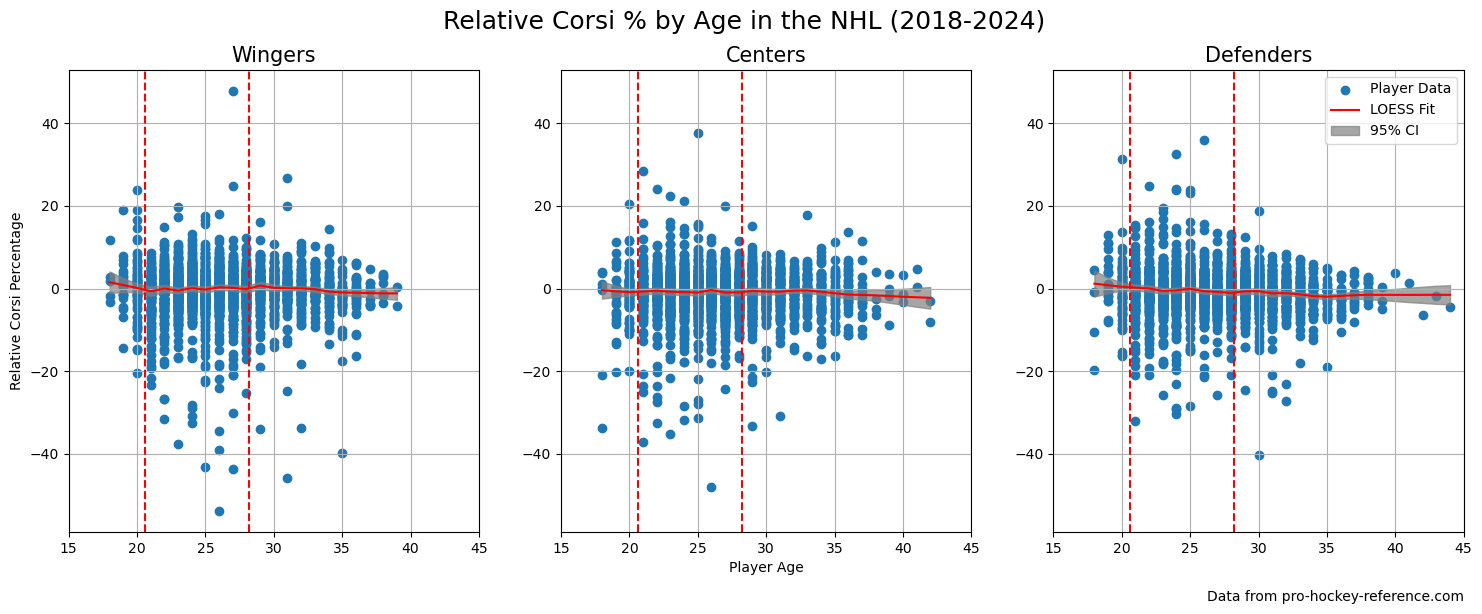

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].scatter(x_dw,y_dw, label='Player Data')
axes[0].plot(xd_fitw,yd_fitw, color='red', label='LOESS Fit')
axes[0].fill_between(xd_fitw, lower_band_w, upper_band_w, color='gray', alpha=0.7, label='95% CI')
axes[0].set_title('Wingers', fontsize=15)
axes[0].set_ylabel('Relative Corsi Percentage')
axes[0].grid(True)
axes[0].set_xlim(15,45)
axes[0].axvline(x=20.6, color='red', linestyle='--')
axes[0].axvline(x=28.2, color='red', linestyle='--')

axes[1].scatter(x_dc,y_dc, label='Player Data')
axes[1].plot(xd_fitc,yd_fitc, color='red', label='LOESS Fit')
axes[1].fill_between(xd_fitc, lower_band_c, upper_band_c, color='gray', alpha=0.7, label='95% CI')
axes[1].set_title('Centers', fontsize=15)
axes[1].set_xlabel('Player Age')
axes[1].grid(True)
axes[1].set_xlim(15,45)
axes[1].yaxis.set_tick_params(labelleft=True)
axes[1].axvline(x=20.6, color='red', linestyle='--')
axes[1].axvline(x=28.2, color='red', linestyle='--')

axes[2].scatter(x_dd,y_dd, label='Player Data')
axes[2].plot(xd_fitd,yd_fitd, color='red', label='LOESS Fit')
axes[2].fill_between(xd_fitd, lower_band_d, upper_band_d, color='gray', alpha=0.7, label='95% CI')
axes[2].set_title('Defenders', fontsize=15)
axes[2].grid(True)
axes[2].set_xlim(15,45)
axes[2].yaxis.set_tick_params(labelleft=True)
axes[2].axvline(x=20.6, color='red', linestyle='--')
axes[2].axvline(x=28.2, color='red', linestyle='--')

fig.suptitle("Relative Corsi % by Age in the NHL (2018-2024)", fontsize=18)
fig.text(0.9, -0.005, "Data from pro-hockey-reference.com", ha='right')
plt.legend();

# Plus / Minus

In [128]:
defender_b = non_goal_b[(non_goal_b['D']==1)]
winger_b = non_goal_b[(non_goal_b['W']==1)]
center_b = non_goal_b[(non_goal_b['C']==1)]

In [129]:
## Defender - Plus/Minus

frac = 0.15

x_dd = defender_b['Age'].values
y_dd = defender_b['+/-'].values
index = np.argsort(x_dd)
x_dd = x_dd[index]
y_dd = y_dd[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dd, x_dd, frac=frac, return_sorted=True)
xd_fitd = loess_result[:, 0]
yd_fitd = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitd)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dd), size=len(x_dd), replace=True)
    y_sample = y_dd[sample_idx]
    x_sample = x_dd[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bd = loess_boot[:,1]
    x_bd = loess_boot[:,0]

    interp = np.interp(xd_fitd, x_bd, y_bd, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_d = np.nanstd(y_boots, axis=0)
upper_band_d = yd_fitd + 1.96 * std_d
lower_band_d = yd_fitd - 1.96 * std_d

## Winger - Plus/Minus

x_dw = winger_b['Age'].values
y_dw = winger_b['+/-'].values
index = np.argsort(x_dw)
x_dw = x_dw[index]
y_dw = y_dw[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dw, x_dw, frac=frac, return_sorted=True)
xd_fitw = loess_result[:, 0]
yd_fitw = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitw)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dw), size=len(x_dw), replace=True)
    y_sample = y_dw[sample_idx]
    x_sample = x_dw[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bw = loess_boot[:,1]
    x_bw = loess_boot[:,0]

    interp = np.interp(xd_fitw, x_bw, y_bw, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_w = np.nanstd(y_boots, axis=0)
upper_band_w = yd_fitw + 1.96 * std_w
lower_band_w = yd_fitw - 1.96 * std_w

## Center - Plus/Minus

x_dc = center_b['Age'].values
y_dc = center_b['+/-'].values
index = np.argsort(x_dc)
x_dc = x_dc[index]
y_dc = y_dc[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dc, x_dc, frac=frac, return_sorted=True)
xd_fitc = loess_result[:, 0]
yd_fitc = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitc)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dc), size=len(x_dc), replace=True)
    y_sample = y_dc[sample_idx]
    x_sample = x_dc[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bc = loess_boot[:,1]
    x_bc = loess_boot[:,0]

    interp = np.interp(xd_fitc, x_bc, y_bc, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_c = np.nanstd(y_boots, axis=0)
upper_band_c = yd_fitc + 1.96 * std_c
lower_band_c = yd_fitc - 1.96 * std_c

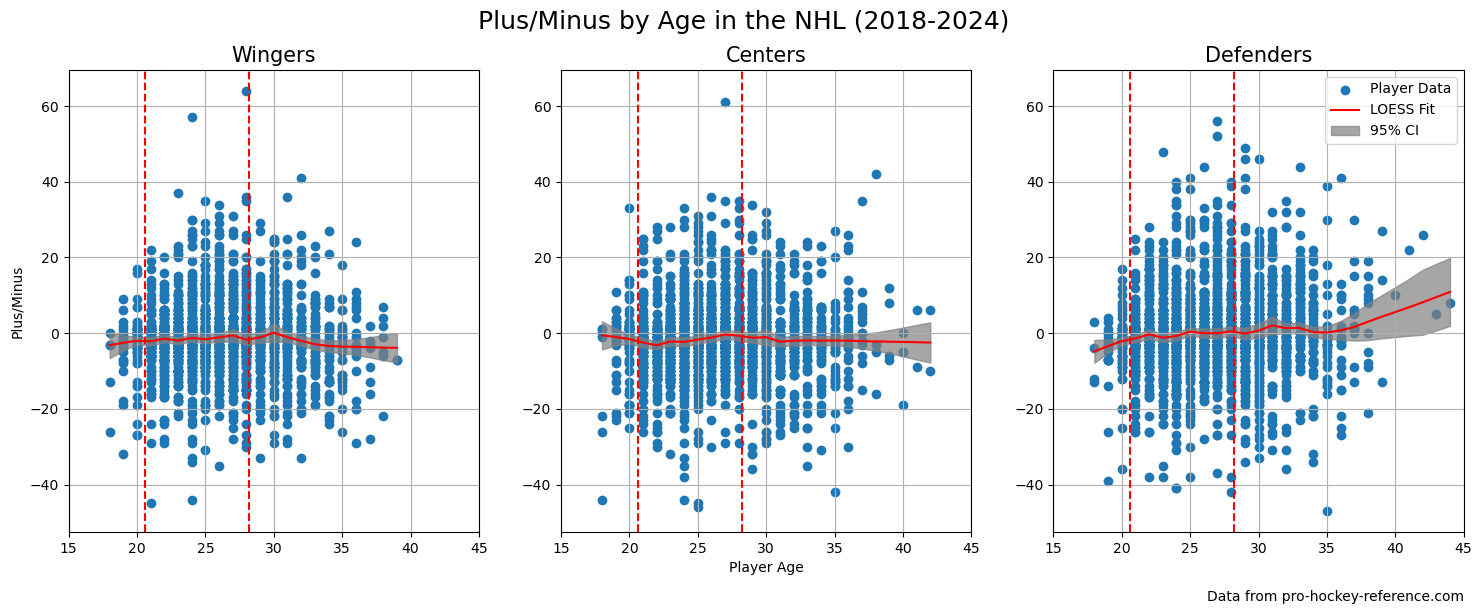

In [130]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].scatter(x_dw,y_dw, label='Player Data')
axes[0].plot(xd_fitw,yd_fitw, color='red', label='LOESS Fit')
axes[0].fill_between(xd_fitw, lower_band_w, upper_band_w, color='gray', alpha=0.7, label='95% CI')
axes[0].set_title('Wingers', fontsize=15)
axes[0].set_ylabel('Plus/Minus')
axes[0].grid(True)
axes[0].set_xlim(15,45)
axes[0].axvline(x=20.6, color='red', linestyle='--')
axes[0].axvline(x=28.2, color='red', linestyle='--')

axes[1].scatter(x_dc,y_dc, label='Player Data')
axes[1].plot(xd_fitc,yd_fitc, color='red', label='LOESS Fit')
axes[1].fill_between(xd_fitc, lower_band_c, upper_band_c, color='gray', alpha=0.7, label='95% CI')
axes[1].set_title('Centers', fontsize=15)
axes[1].set_xlabel('Player Age')
axes[1].grid(True)
axes[1].set_xlim(15,45)
axes[1].yaxis.set_tick_params(labelleft=True)
axes[1].axvline(x=20.6, color='red', linestyle='--')
axes[1].axvline(x=28.2, color='red', linestyle='--')

axes[2].scatter(x_dd,y_dd, label='Player Data')
axes[2].plot(xd_fitd,yd_fitd, color='red', label='LOESS Fit')
axes[2].fill_between(xd_fitd, lower_band_d, upper_band_d, color='gray', alpha=0.7, label='95% CI')
axes[2].set_title('Defenders', fontsize=15)
axes[2].grid(True)
axes[2].set_xlim(15,45)
axes[2].yaxis.set_tick_params(labelleft=True)
axes[2].axvline(x=20.6, color='red', linestyle='--')
axes[2].axvline(x=28.2, color='red', linestyle='--')

fig.suptitle("Plus/Minus by Age in the NHL (2018-2024)", fontsize=18)
fig.text(0.9, -0.005, "Data from pro-hockey-reference.com", ha='right')
plt.legend();

# Goals and Assists

In [131]:
# Create and Normalize Goals and Assists Columns

non_goal_b['G+A'] = non_goal_b['G'] + non_goal_b['A']
ga_mean = np.mean(non_goal_b['G+A'])
ga_std = np.std(non_goal_b['G+A'])

non_goal_b['GA_norm'] = (non_goal_b['G+A'] - ga_mean) / ga_std

defender_b = non_goal_b[(non_goal_b['D']==1)]
winger_b = non_goal_b[(non_goal_b['W']==1)]
center_b = non_goal_b[(non_goal_b['C']==1)]

In [132]:
## Defender - Goals + Assists

frac = 0.15

x_dd = defender_b['Age'].values
y_dd = defender_b['GA_norm'].values
index = np.argsort(x_dd)
x_dd = x_dd[index]
y_dd = y_dd[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dd, x_dd, frac=frac, return_sorted=True)
xd_fitd = loess_result[:, 0]
yd_fitd = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitd)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dd), size=len(x_dd), replace=True)
    y_sample = y_dd[sample_idx]
    x_sample = x_dd[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bd = loess_boot[:,1]
    x_bd = loess_boot[:,0]

    interp = np.interp(xd_fitd, x_bd, y_bd, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_d = np.nanstd(y_boots, axis=0)
upper_band_d = yd_fitd + 1.96 * std_d
lower_band_d = yd_fitd - 1.96 * std_d

## Winger - Goals + Assists

x_dw = winger_b['Age'].values
y_dw = winger_b['GA_norm'].values
index = np.argsort(x_dw)
x_dw = x_dw[index]
y_dw = y_dw[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dw, x_dw, frac=frac, return_sorted=True)
xd_fitw = loess_result[:, 0]
yd_fitw = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitw)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dw), size=len(x_dw), replace=True)
    y_sample = y_dw[sample_idx]
    x_sample = x_dw[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bw = loess_boot[:,1]
    x_bw = loess_boot[:,0]

    interp = np.interp(xd_fitw, x_bw, y_bw, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_w = np.nanstd(y_boots, axis=0)
upper_band_w = yd_fitw + 1.96 * std_w
lower_band_w = yd_fitw - 1.96 * std_w

## Center - Goals + Assists

x_dc = center_b['Age'].values
y_dc = center_b['GA_norm'].values
index = np.argsort(x_dc)
x_dc = x_dc[index]
y_dc = y_dc[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_dc, x_dc, frac=frac, return_sorted=True)
xd_fitc = loess_result[:, 0]
yd_fitc = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fitc)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_dc), size=len(x_dc), replace=True)
    y_sample = y_dc[sample_idx]
    x_sample = x_dc[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=frac, return_sorted=True)
    y_bc = loess_boot[:,1]
    x_bc = loess_boot[:,0]

    interp = np.interp(xd_fitc, x_bc, y_bc, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std_c = np.nanstd(y_boots, axis=0)
upper_band_c = yd_fitc + 1.96 * std_c
lower_band_c = yd_fitc - 1.96 * std_c

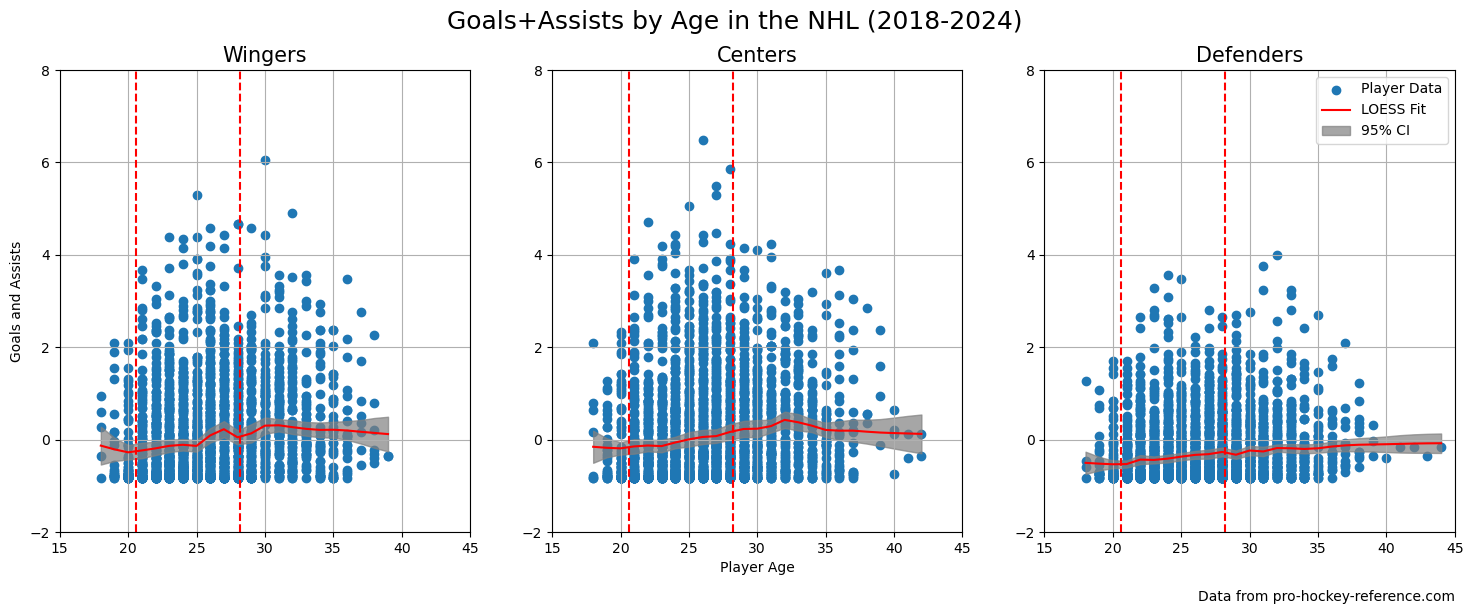

In [133]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].scatter(x_dw,y_dw, label='Player Data')
axes[0].plot(xd_fitw,yd_fitw, color='red', label='LOESS Fit')
axes[0].fill_between(xd_fitw, lower_band_w, upper_band_w, color='gray', alpha=0.7, label='95% CI')
axes[0].set_title('Wingers', fontsize=15)
axes[0].set_ylabel('Goals and Assists')
axes[0].grid(True)
axes[0].set_xlim(15,45)
axes[0].axvline(x=20.6, color='red', linestyle='--')
axes[0].axvline(x=28.2, color='red', linestyle='--')
axes[0].set_ylim(-2,8)

axes[1].scatter(x_dc,y_dc, label='Player Data')
axes[1].plot(xd_fitc,yd_fitc, color='red', label='LOESS Fit')
axes[1].fill_between(xd_fitc, lower_band_c, upper_band_c, color='gray', alpha=0.7, label='95% CI')
axes[1].set_title('Centers', fontsize=15)
axes[1].set_xlabel('Player Age')
axes[1].grid(True)
axes[1].set_xlim(15,45)
axes[1].yaxis.set_tick_params(labelleft=True)
axes[1].axvline(x=20.6, color='red', linestyle='--')
axes[1].axvline(x=28.2, color='red', linestyle='--')

axes[2].scatter(x_dd,y_dd, label='Player Data')
axes[2].plot(xd_fitd,yd_fitd, color='red', label='LOESS Fit')
axes[2].fill_between(xd_fitd, lower_band_d, upper_band_d, color='gray', alpha=0.7, label='95% CI')
axes[2].set_title('Defenders', fontsize=15)
axes[2].grid(True)
axes[2].set_xlim(15,45)
axes[2].yaxis.set_tick_params(labelleft=True)
axes[2].axvline(x=20.6, color='red', linestyle='--')
axes[2].axvline(x=28.2, color='red', linestyle='--')

fig.suptitle("Goals+Assists by Age in the NHL (2018-2024)", fontsize=18)
fig.text(0.9, -0.005, "Data from pro-hockey-reference.com", ha='right')
plt.legend();